In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from numba import njit
from time import time 
from scipy.linalg import null_space
from numpy.linalg import det, inv, norm as numpy_norm, matrix_rank as rank
from numpy import trace
from skimage.io import imread

In [2]:
def get_matches(src, dst):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(src,None)
    kp2, des2 = sift.detectAndCompute(dst,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    return src_pts, dst_pts

In [21]:
img1 = cv2.imread('messR.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('messL.png',cv2.IMREAD_GRAYSCALE)

In [22]:
def get_F(img1,img2):
    pts1, pts2 = get_matches(img1, img2)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_7POINT) #cv2.FM_LMEDS)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    return pts1, pts2, F, mask

In [23]:
pts1, pts2, F, mask = get_F(img1,img2)

In [24]:
def plot_(img1,img2,pts1,pts2, F):
    def drawlines(img1,img2,lines,pts1,pts2):
        ''' img1 - image on which we draw the epilines for the points in img2
            lines - corresponding epilines '''
        r,c = img1.shape
        img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
        img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
        for r,pt1,pt2 in zip(lines,pts1,pts2):
            color = tuple(np.random.randint(0,255,3).tolist())
            x0,y0 = map(int, [0, -r[2]/r[1] ])
            x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
            img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
            img1 = cv2.circle(img1,tuple(pt1.ravel().astype(np.int64)),5,color,-1)
            img2 = cv2.circle(img2,tuple(pt2.ravel().astype(np.int64)),5,color,-1)
        return img1,img2
    
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5, img6 = drawlines(img1,img2,lines1,pts1,pts2)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(30,30))
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

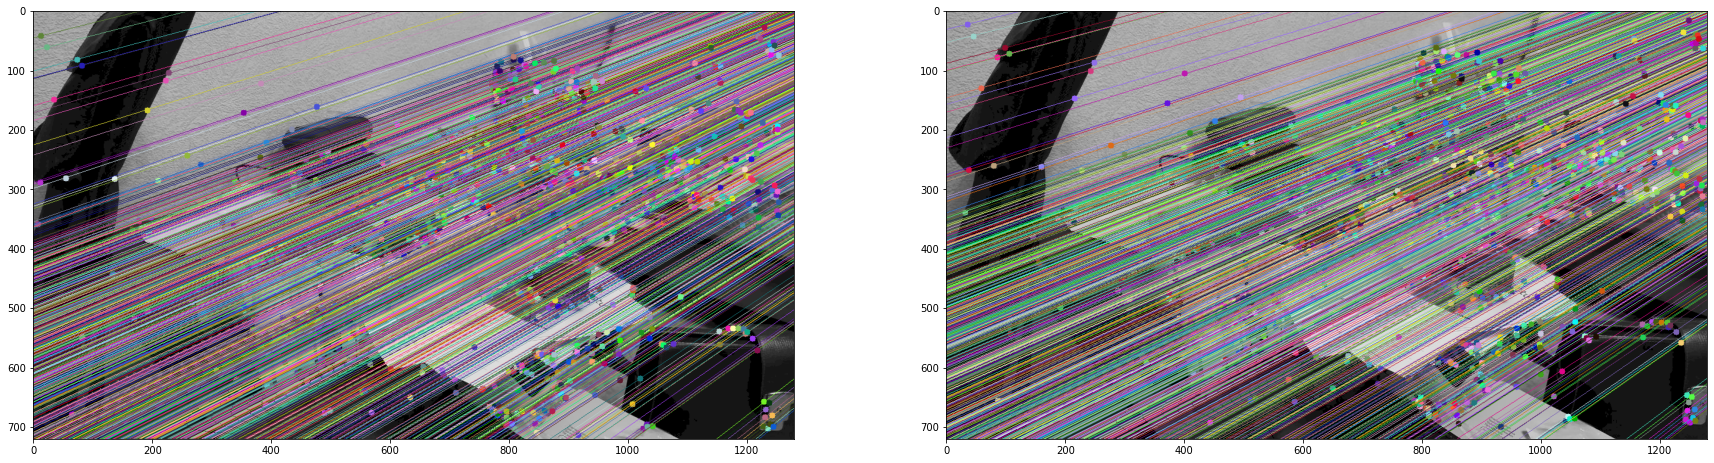

In [25]:
plot_(img1,img2,pts1,pts2,F)

In [26]:
h1, w1 = img1.shape
h2, w2 = img2.shape
thresh = 0
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1), threshold=thresh,
)
rec_img1 = cv2.warpPerspective(img1, H1, (1*w1, 1*h1))
rec_img2 = cv2.warpPerspective(img2, H2, (1*w2, 1*h2))

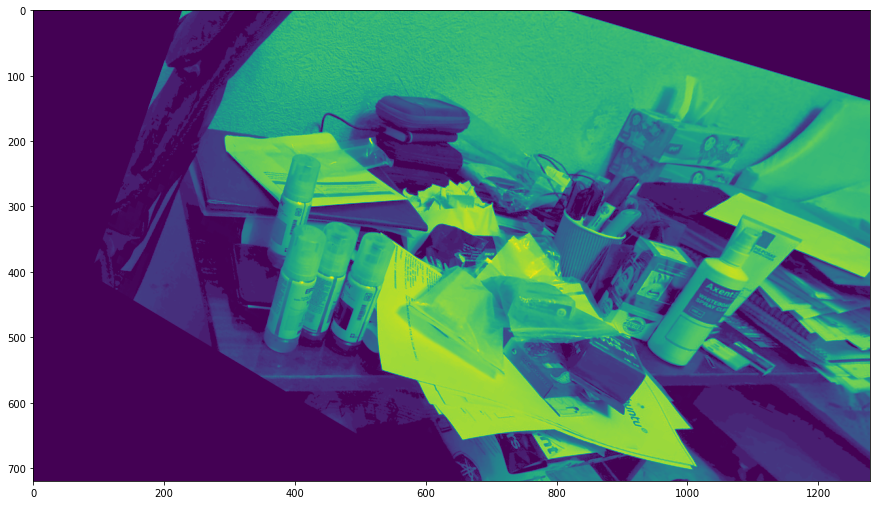

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(rec_img1)

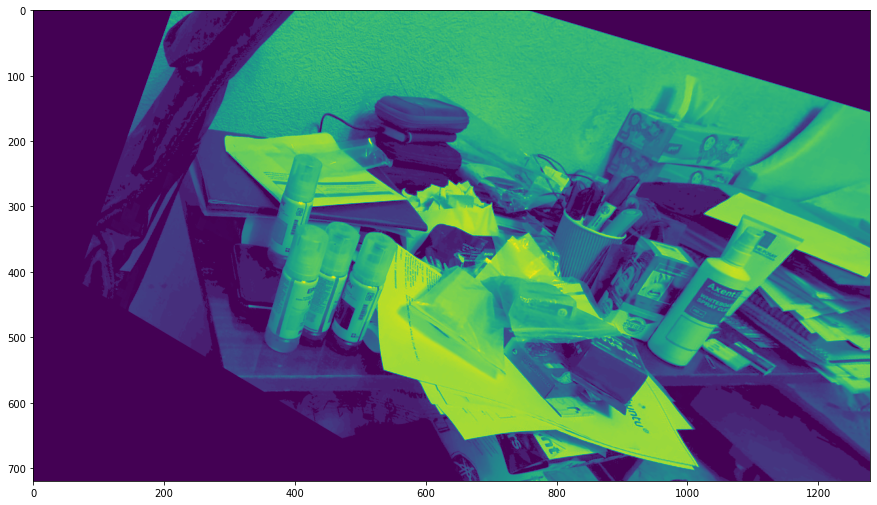

In [28]:
plt.figure(figsize=(15,15))
plt.imshow(rec_img2)

In [29]:
pts1_opencv, pts2_opencv, F_opencv, mask_opencv = get_F(rec_img1,rec_img2)

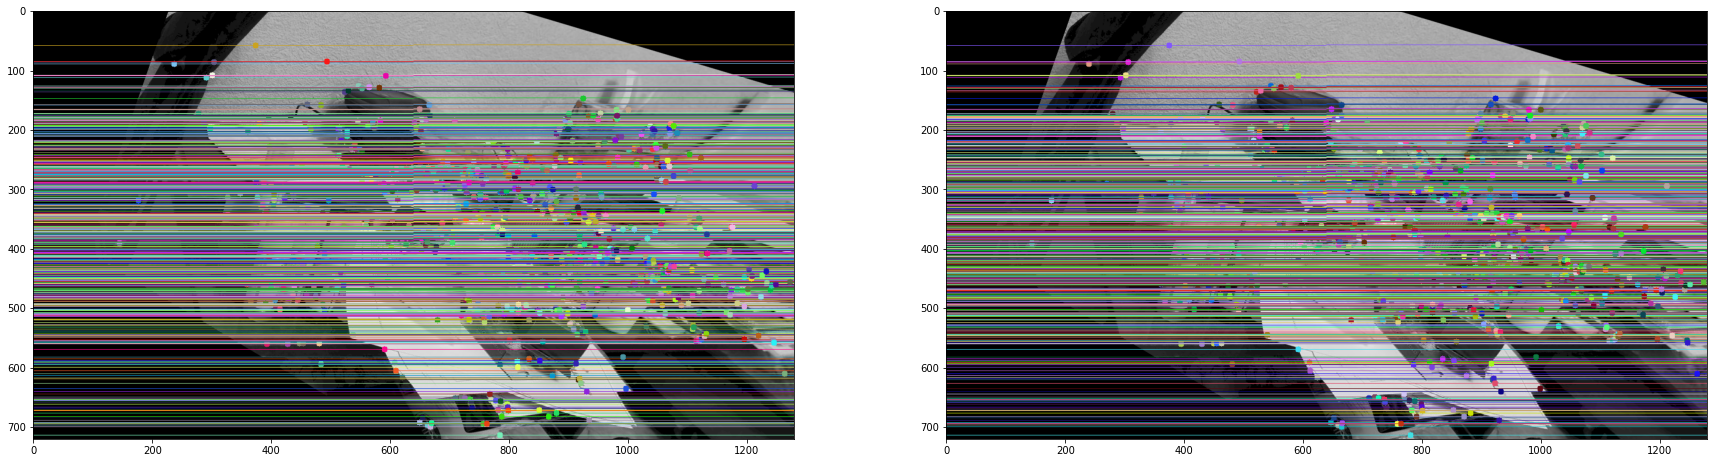

In [30]:
plot_(rec_img1,rec_img2,pts1_opencv,pts2_opencv,F_opencv)

In [31]:
k = np.array([0,0,1])
er = null_space(F.T).ravel()
er = er/er[-1]

In [32]:
Rr = np.zeros((3,3))
Rr[0,:] = np.cross(k,np.cross(er,k))/np.linalg.norm(np.cross(k,np.cross(er,k)))
Rr[1,:] = np.cross(k,er)/np.linalg.norm(np.cross(k,er))
Rr[2,:] = k - np.cross(k,np.cross(er,k))/(   np.cross(k,np.cross(er,k))@er        )

In [33]:
Rl_prime = np.zeros((3,3))
Rl_prime[2,:] = np.cross(k,er)@F*(   1+ 1/(      np.cross(k,np.cross(er,k))@er            )     )
Rl_prime[1,:] = (np.cross(np.cross(k,er),er)@F)/np.linalg.norm(np.cross(np.cross(k,er),k))
Rl_prime[0,:] = np.cross(Rl_prime[1,:], Rl_prime[2,:])

In [34]:
pts1_with_ones = np.dstack((pts2,  np.ones((pts1.shape[0],1)))).reshape(-1,3,1)
pts2_with_ones = np.dstack((pts1,  np.ones((pts2.shape[0],1)))).reshape(-1,3,1)

In [35]:
right_part = np.matmul(Rr,pts2_with_ones).reshape(-1,3)
right_part = right_part[:,0]/right_part[:,2]

left_part = np.matmul(Rl_prime,pts1_with_ones).reshape(-1,3)
left_part = left_part/ left_part[:,2,np.newaxis]

In [36]:
a,b,c  = np.linalg.lstsq(left_part,right_part,rcond = None)[0]

In [37]:
Rl = np.array([[a,b,c],
              [0,1,0],
              [0,0,1]])@Rl_prime
Rl = Rl/Rl[-1,-1]

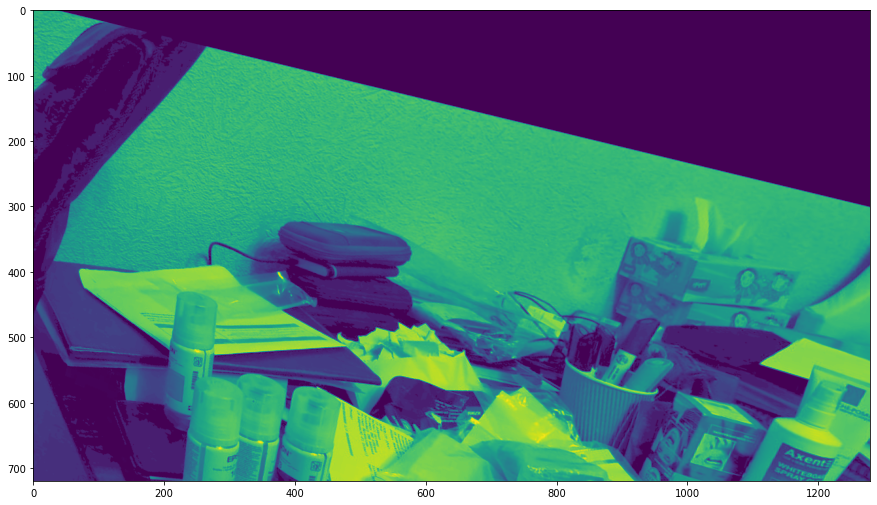

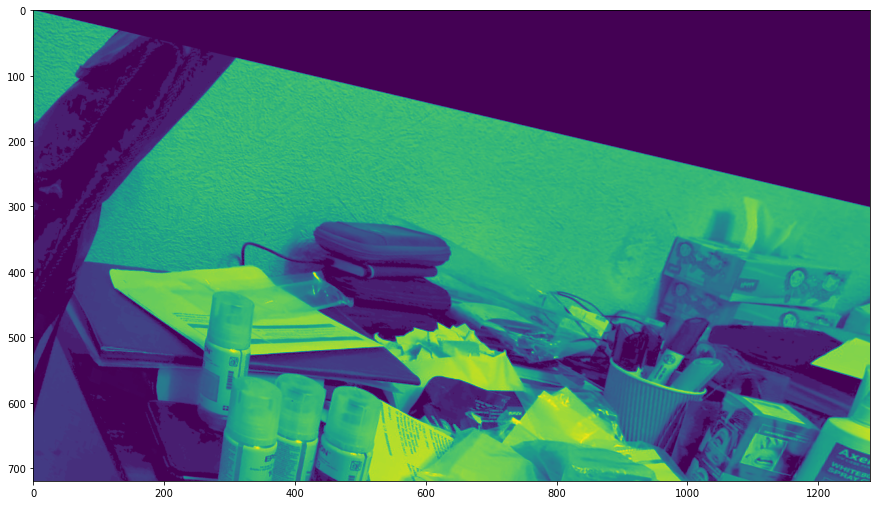

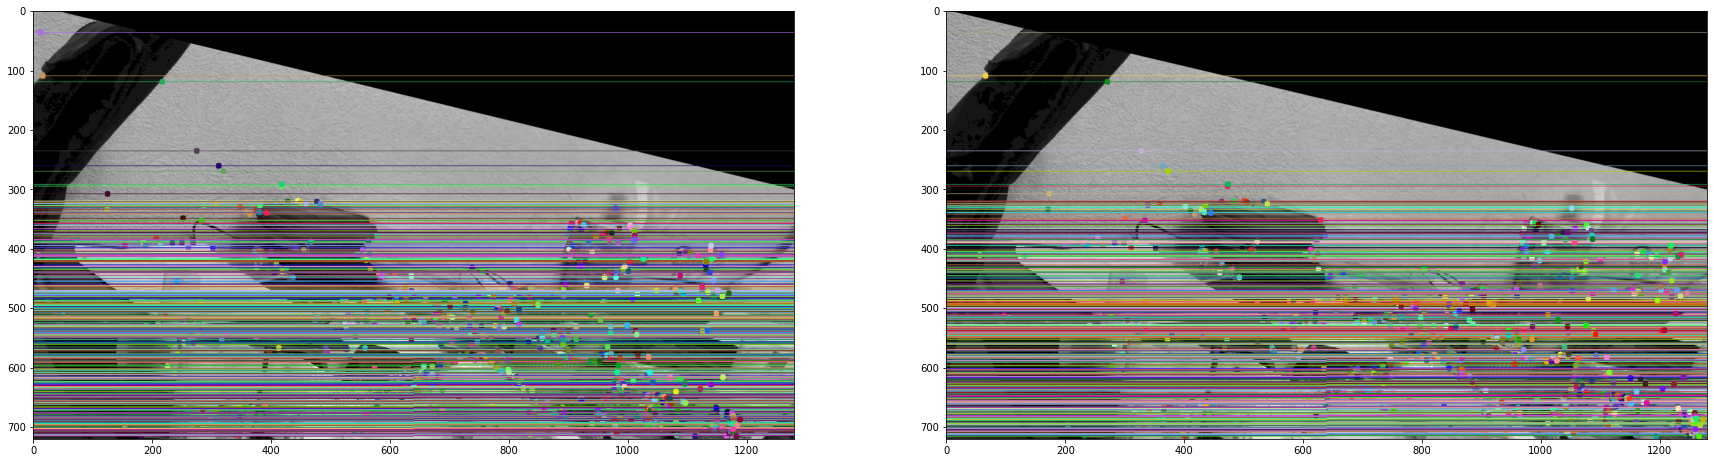

In [38]:
h1, w1 = img1.shape
h2, w2 = img2.shape

rec_img1 = cv2.warpPerspective(img1, Rl, (1*w1, 1*h1))
rec_img2 = cv2.warpPerspective(img2, Rr, (1*w2, 1*h2))


plt.figure(figsize=(15,15))
plt.imshow(rec_img1)

plt.figure(figsize=(15,15))
plt.imshow(rec_img2)

pts1_opencv, pts2_opencv,F_opencv, mask_opencv = get_F(rec_img1,rec_img2)
plot_(rec_img1,rec_img2,pts1_opencv,pts2_opencv,F_opencv)